In [2]:
# Import

# Basic
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



---
# My Plan

My ultimate objective is to predict the probability of credit card defaults. My plan is to develop a classification algorithm, to predict if a user is going to default. Then, I can predict the probability of default based on the number of predicted default users.

1. Load data and check columns
2. Calculate the percentage of credit card defaults out of all the users\
3. Explore the whole dataset and find any interesting insights
4. Evaluate the data quality and figure out whether outliers exist
5. Clean Data
6. Select the strongest predictors 
7. Perform feature engineering


---
# 1. Loading Credit Card User Data

In [3]:
# Load the data
df = pd.read_csv('dataset/data.csv') 
df.dtypes


ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
PAY_1                         float64
dtype: objec

---

PAY_1 is not in the data dictionary. Let's see whats in it.

In [4]:
df.PAY_1

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9995   NaN
9996   NaN
9997   NaN
9998   NaN
9999   NaN
Name: PAY_1, Length: 10000, dtype: float64

Looks like its all missing values. Let's do a quick check.

In [5]:
df.groupby(df.PAY_1.astype(str)).agg({'ID':'count'})

,ID
PAY_1,
0.0,100
nan,9900


Yes, almost all of it are missing values. 100 of them are labelled as 0 but 0 has not be defined in the data dictionary. So, there is no meaningful data in this column.

Therefore, I have decided to remove PAY_1.



In [6]:
df.drop(columns=['PAY_1'], inplace=True)
df.dtypes


ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

---
On the other hand, according to the dictionary, PAY_0 is the Repayment status in September, which is inconsistent with the labelling of BILL_AMT1 (September) and PAY_AMT1 (September). Therefore, I believe 'PAY_0' was a mislabelled. I will rename it as PAY_1.

In [7]:
# fixing the names
df = df.rename(columns={'PAY_0': 'PAY_1'})
df.dtypes



ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_1                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

---
I found the field name 'default.payment.next.month' not easy to use. Therefore, I am going to rename it as 'DEFAULT_PAY'.


In [8]:
# fixing the names
df = df.rename(columns={'default.payment.next.month': 'DEFAULT_PAY'})
df.dtypes


ID               int64
LIMIT_BAL      float64
SEX              int64
EDUCATION        int64
MARRIAGE         int64
AGE              int64
PAY_1            int64
PAY_2            int64
PAY_3            int64
PAY_4            int64
PAY_5            int64
PAY_6            int64
BILL_AMT1      float64
BILL_AMT2      float64
BILL_AMT3      float64
BILL_AMT4      float64
BILL_AMT5      float64
BILL_AMT6      float64
PAY_AMT1       float64
PAY_AMT2       float64
PAY_AMT3       float64
PAY_AMT4       float64
PAY_AMT5       float64
PAY_AMT6       float64
DEFAULT_PAY      int64
dtype: object

---
# 2. Calculate the percentage of credit card defaults out of all the users


In [9]:
df.DEFAULT_PAY.sum() / len(df.DEFAULT_PAY)


0.2238

22% of credit card user have defaulted. 

In mentioned earlier, I have to develop a classification algorithm. However, given this uneven class distribution (78% vs 22%), we have to be careful when choosing our evaluation metric. F1 is, in my knowledge, the best candidate.



---
# 3. Explore the whole dataset and find any interesting insights


In [10]:
# create a copy of df so that I could improve the labelling of categories. 
df_explore = df.copy()

---
## 3.1. Categorical data
There are Sex, Education and Marriage.


---
### Sex
Key: 1=male, 2=female


In [11]:
# relabel
df_explore['SEX'] = df_explore['SEX'].replace([1,2],['male','female'])


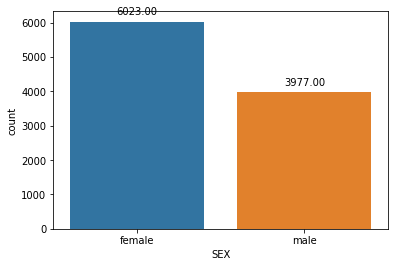

In [12]:
def bar_chart(df, col):
    ax = sns.countplot(x=col, data=df)
    
    for p in ax.patches:
        ax.annotate(\
            format(p.get_height(), '.2f'), \
            (p.get_x() + p.get_width() / 2., p.get_height()), \
            ha = 'center', va = 'center', \
            xytext = (0, 10), \
            textcoords = 'offset points')

bar_chart(df_explore, 'SEX')

    

In [13]:
def d_rate_by_col(df, col):
    d_rate = df.groupby([col, 'DEFAULT_PAY']).size().unstack()
    d_rate['perc'] = \
        (d_rate[d_rate.columns[1]]/(d_rate[d_rate.columns[0]] + d_rate[d_rate.columns[1]]))
    return d_rate

d_rate_by_col(df_explore, 'SEX')

DEFAULT_PAY,0,1,perc
SEX,,,
female,4723,1300,0.215839
male,3039,938,0.235856


There are more female than male.

Male are more likely to default than Female. 


---
### Education
Key: 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown


In [14]:
df_explore.groupby(df_explore.EDUCATION.astype(str)).agg({'ID':'count'})


,ID
EDUCATION,
0,8
1,3514
2,4585
3,1633
4,46
5,90
6,124


0 has not been defined in the data dictionary. So, I am going to group it together with 5 and 6 (both unknown).

In addition, 4 only has 46 samples. It is not going to be a strong predictor anyway so I am going to merge it with the unknown group.

In [15]:
# relabel and re-group
df_explore['EDUCATION'] = \
    df_explore['EDUCATION'].replace([0,4,5,6],'unknown_and_others')
df_explore['EDUCATION'] = df_explore['EDUCATION'].replace([1,2,3],['graduate_school','university','high_school'])


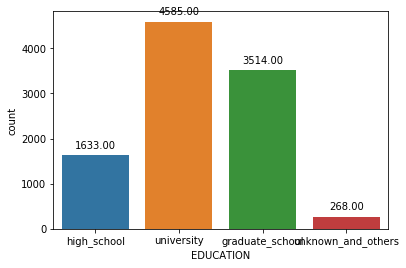

In [16]:
bar_chart(df_explore, 'EDUCATION')

In [17]:
d_rate_by_col(df_explore, 'EDUCATION')

DEFAULT_PAY,0,1,perc
EDUCATION,,,
graduate_school,2819,695,0.197780
high_school,1223,410,0.251072
university,3465,1120,0.244275
unknown_and_others,255,13,0.048507


Most users are university students. The second biggest group is graduate students.

It seems like the higher the education level (high school < university < graduate school) the lower the default rate.  


---

### Marriage
Key: 1=married, 2=single, 3=others

In [18]:
df_explore.groupby(df_explore.MARRIAGE.astype(str)).agg({'ID':'count'})


,ID
MARRIAGE,
0,13
1,4476
2,5287
3,224


0 has not been defined in the data dictionary. It only has 13 samples. So, I am going to group it with 3 (others).


In [19]:
# relabel and re-group
df_explore['MARRIAGE'] = \
    df_explore['MARRIAGE'].replace([0,3],'unknown_and_others')
df_explore['MARRIAGE'] = df_explore['MARRIAGE'].replace([1,2],['married','single'])


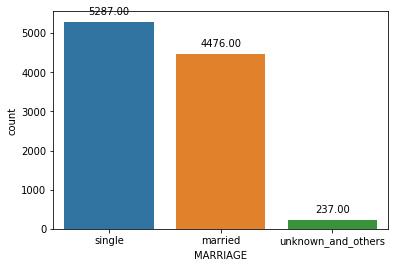

In [20]:
bar_chart(df_explore, 'MARRIAGE')

In [21]:
d_rate_by_col(df_explore, 'MARRIAGE')

DEFAULT_PAY,0,1,perc
MARRIAGE,,,
married,3393,1083,0.241957
single,4175,1112,0.210327
unknown_and_others,194,43,0.181435


Most users are single. 

Married users have higher default rate.


---

## 3.1. Continuous data
There are 
- Credit, 
- Age, 
- Repayment status in month X, 
- Amount of bill statement in month X,
- Amount of previous payment in month X.

---

### Credit


No handles with labels found to put in legend.


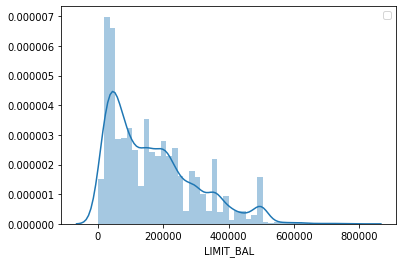

In [27]:
sns.distplot( df_explore['LIMIT_BAL'])
plt.legend()


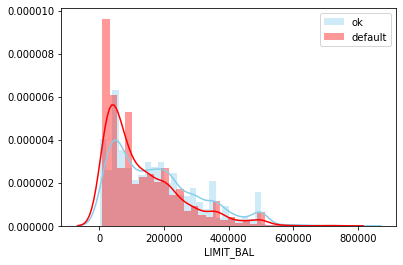

In [28]:
def def_dist(df, col):
    sns.distplot(df.loc[df.DEFAULT_PAY==0,col], color='skyblue', label='ok')
    sns.distplot(df.loc[df.DEFAULT_PAY==1,col], color='red', label='default')
    plt.legend()

def_dist(df_explore, 'LIMIT_BAL')



The distribution of credit is skewed, with a long tail of high credit users.

As expected, the most defaulted users have lower credits.

---

### Age


No handles with labels found to put in legend.


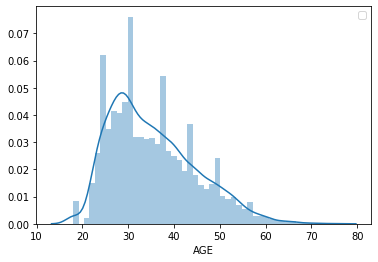

In [29]:
sns.distplot( df_explore['AGE'])
plt.legend()


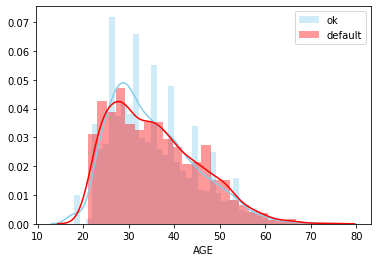

In [31]:
def_dist(df_explore, 'AGE')



The distribution of age is skewed, with a long tail of older users.


---

### Bill, Payment and Repayment Status
- BILL_AMT: Amount of bill statement in XXXX
- PAY_AMT: Amount of previous payment in XXXX
- PAY: Repayment status in XXXX, (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)



 To understand the relationship among the factors, I have selected  


In [75]:
sel_filter = ((df.PAY_6 == -1) & (df.BILL_AMT6 > 0))
df_explore[sel_filter][['BILL_AMT6', 'PAY_AMT6', 'PAY_6', 'BILL_AMT5', 'PAY_AMT5', 'PAY_5']].sample(20)

,BILL_AMT6,PAY_AMT6,PAY_6,BILL_AMT5,PAY_AMT5,PAY_5
4523,4533.0,0.0,-1,2202.0,5131.0,0
865,3019.0,4302.0,-1,3608.0,3103.0,-1
2960,2318.0,3311.0,-1,2048.0,2318.0,-1
5485,5824.0,48366.0,-1,9279.0,5849.0,0
9939,4298.0,12330.0,-1,11560.0,4298.0,-1
3032,11960.0,65157.0,-1,12234.0,1200.0,-1
7518,4320.0,1650.0,-1,702.0,4320.0,-1
7410,735.0,735.0,-1,735.0,735.0,-1
3885,5110.0,9028.0,-1,3343.0,5124.0,-1
4620,1312.0,0.0,-1,1073.0,1500.0,-1


In [90]:
df_explore[sel_filter].groupby(df_explore.BILL_AMT6<=df_explore.PAY_AMT5).agg({'ID':'count'})


,ID
False,41
True,1670


In [93]:
sel_filter = ((df.PAY_5 == -1) & (df.BILL_AMT5 > 0))
df_explore[sel_filter][['BILL_AMT5', 'PAY_AMT5', 'PAY_5', 'BILL_AMT4', 'PAY_AMT4', 'PAY_4']].sample(20)

,BILL_AMT5,PAY_AMT5,PAY_5,BILL_AMT4,PAY_AMT4,PAY_4
724,166251.0,5506.0,-1,6288.0,178460.0,-1
1099,6261.0,6261.0,-1,6261.0,6261.0,-1
8476,318.0,0.0,-1,0.0,318.0,-2
1731,2497.0,2830.0,-1,2779.0,2497.0,0
1638,662.0,3295.0,-1,303.0,662.0,-1
7504,1567.0,1707.0,-1,3365.0,1567.0,-1
7555,1230.0,1054.0,-1,1054.0,1230.0,-1
8283,7247.0,13959.0,-1,15181.0,7283.0,-1
749,2500.0,10000.0,-1,180.0,2500.0,-1
4920,1150.0,0.0,-1,10400.0,1150.0,0


In [92]:
df_explore[sel_filter].groupby(df_explore.BILL_AMT5<=df_explore.PAY_AMT4).agg({'ID':'count'})

,ID
False,382
True,1329


In [60]:
sel_filter = (
        (df_explore.PAY_AMT1 >= df_explore.BILL_AMT2)\
        &(df_explore.PAY_AMT1!=0)\
        &(df_explore.BILL_AMT2!=0))

print(df_explore[sel_filter]['ID'].count())
#df_explore[sel_filter][np.array(col_names)].sample(10)
df_explore[sel_filter].groupby('PAY_1').agg({'ID':'count'})

2324


,ID
PAY_1,
-2,556
-1,1300
0,191
1,225
2,52


In [45]:
sel_filter = (
        (df_explore.PAY_AMT2 == df_explore.BILL_AMT2)\
        &(df_explore.PAY_AMT2!=0)\
        &(df_explore.BILL_AMT2!=0))

df_explore[sel_filter]['ID'].count()

198

In [66]:
sel_filter = \
        ((df_explore.PAY_AMT5!=0)\
        &(df_explore.BILL_AMT6!=0))

print(df_explore[sel_filter]['ID'].count())

sel_filter = \
        ((df_explore.PAY_AMT5 == df_explore.BILL_AMT6)\
        &(df_explore.PAY_AMT5!=0)\
        &(df_explore.BILL_AMT6!=0))

print(df_explore[sel_filter]['ID'].count())






7656
1563
